In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
train_batch_losses = []
train_epoch_accuracies = []
test_epoch_accuracies = []

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")
print(f"Using device: {device}")

best_test_accuracy = 0.0
best_model_state = None

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, 
                                            transform=train_transform)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=64,
                                              shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=True, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv, num_kernel_size, num_padding):
        super(Block, self).__init__()

        self.num_conv = num_conv

        for i in range(num_conv):
            conv_layer = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=num_kernel_size,
                                   padding=num_padding)

            nn.init.kaiming_normal_(conv_layer.weight, mode='fan_in', nonlinearity='relu')
            if conv_layer.bias is not None:
                nn.init.constant_(conv_layer.bias, 0)

            conv = nn.Sequential(
                conv_layer,
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True))

            setattr(self, f'conv{i + 1}', conv)

        self.fc = nn.Linear(in_channels, num_conv)
        nn.init.kaiming_normal_(self.fc.weight, mode='fan_in', nonlinearity='relu')
        if self.fc.bias is not None:
            nn.init.constant_(self.fc.bias, 0)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        m = x.mean(dim=[2, 3])
        a = self.fc(m)
        a = F.softmax(a, dim=1)

        out = torch.zeros_like(getattr(self, 'conv1')(x))

        for i in range(self.num_conv):
            conv = getattr(self, f'conv{i + 1}')
            out += a[:, i].view(-1, 1, 1, 1) * conv(x)

        out = self.pool(out)
        return out

In [4]:
class ConvNet(nn.Module):
    def __init__(self, block_configs, num_classes=10):
        super(ConvNet, self).__init__()

        self.blocks = nn.ModuleList()

        for i, cfg in enumerate(block_configs):
            in_ch = cfg['in_channels']
            out_ch = cfg['out_channels']
            num_conv = cfg['num_conv']
            num_kernel_size = cfg['num_kernel_size']
            num_padding = cfg['num_padding']

            self.blocks.append(Block(in_ch, out_ch, num_conv, num_kernel_size, num_padding))

        final_out_channels = block_configs[-1]['out_channels']
        self.output_layer = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(final_out_channels, num_classes))

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        m = x.mean(dim=[2, 3])
        logits = self.output_layer(m)

        return logits

In [5]:
model = ConvNet(block_configs=[
    {'in_channels': 3, 'out_channels': 64, 'num_conv': 5, 'num_kernel_size': 5, 'num_padding': 2},
    {'in_channels': 64, 'out_channels': 128, 'num_conv': 5, 'num_kernel_size': 3, 'num_padding': 1},
    {'in_channels': 128, 'out_channels': 256, 'num_conv': 5, 'num_kernel_size': 3, 'num_padding': 1},
    {'in_channels': 256, 'out_channels': 512, 'num_conv': 5, 'num_kernel_size': 3, 'num_padding': 1}])


In [6]:
model.to(device)
print(f"Model is actually on: {next(model.parameters()).device}")

epochs = 150
# Loss & optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(training_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_batch_losses.append(loss.item())  

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    train_acc = correct / total
    train_epoch_accuracies.append(train_acc) 

    test_acc = evaluate(model, test_loader, device)  
    test_epoch_accuracies.append(test_acc)          

    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        best_model_state = model.state_dict()
        print('This was the best model yet!')
        # Save best model in memory

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(training_loader):.4f} | "
          f"Train Accuracy: {train_acc*100:.2f}% | Test Accuracy: {test_acc*100:.2f}%")


model.load_state_dict(best_model_state)
final_test_acc = evaluate(model, test_loader, device)
print(f"\nFinal Test Accuracy using best model: {final_test_acc*100:.2f}%")

Model is actually on: cuda:0


Epoch 1/150:   0%|          | 0/782 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/150: 100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


Test Accuracy: 50.58%
This was the best model yet!
Epoch 1 - Loss: 1.8510 | Train Accuracy: 39.06% | Test Accuracy: 50.58%


Epoch 2/150: 100%|██████████| 782/782 [00:36<00:00, 21.27it/s]


Test Accuracy: 66.06%
This was the best model yet!
Epoch 2 - Loss: 1.3973 | Train Accuracy: 60.23% | Test Accuracy: 66.06%


Epoch 3/150: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s]


Test Accuracy: 67.63%
This was the best model yet!
Epoch 3 - Loss: 1.2216 | Train Accuracy: 69.41% | Test Accuracy: 67.63%


Epoch 4/150: 100%|██████████| 782/782 [00:36<00:00, 21.38it/s]


Test Accuracy: 76.34%
This was the best model yet!
Epoch 4 - Loss: 1.1434 | Train Accuracy: 73.06% | Test Accuracy: 76.34%


Epoch 5/150: 100%|██████████| 782/782 [00:36<00:00, 21.18it/s]


Test Accuracy: 78.08%
This was the best model yet!
Epoch 5 - Loss: 1.0898 | Train Accuracy: 75.92% | Test Accuracy: 78.08%


Epoch 6/150: 100%|██████████| 782/782 [00:38<00:00, 20.49it/s]


Test Accuracy: 79.65%
This was the best model yet!
Epoch 6 - Loss: 1.0476 | Train Accuracy: 78.03% | Test Accuracy: 79.65%


Epoch 7/150: 100%|██████████| 782/782 [00:36<00:00, 21.63it/s]


Test Accuracy: 78.78%
Epoch 7 - Loss: 1.0217 | Train Accuracy: 79.15% | Test Accuracy: 78.78%


Epoch 8/150: 100%|██████████| 782/782 [00:38<00:00, 20.29it/s]


Test Accuracy: 79.99%
This was the best model yet!
Epoch 8 - Loss: 1.0016 | Train Accuracy: 80.28% | Test Accuracy: 79.99%


Epoch 9/150: 100%|██████████| 782/782 [00:34<00:00, 22.59it/s]


Test Accuracy: 80.98%
This was the best model yet!
Epoch 9 - Loss: 0.9794 | Train Accuracy: 81.47% | Test Accuracy: 80.98%


Epoch 10/150: 100%|██████████| 782/782 [00:38<00:00, 20.39it/s]


Test Accuracy: 81.83%
This was the best model yet!
Epoch 10 - Loss: 0.9633 | Train Accuracy: 82.12% | Test Accuracy: 81.83%


Epoch 11/150: 100%|██████████| 782/782 [00:35<00:00, 21.85it/s]


Test Accuracy: 81.97%
This was the best model yet!
Epoch 11 - Loss: 0.9496 | Train Accuracy: 82.86% | Test Accuracy: 81.97%


Epoch 12/150: 100%|██████████| 782/782 [00:32<00:00, 24.37it/s]


Test Accuracy: 83.37%
This was the best model yet!
Epoch 12 - Loss: 0.9396 | Train Accuracy: 83.35% | Test Accuracy: 83.37%


Epoch 13/150: 100%|██████████| 782/782 [00:37<00:00, 20.68it/s]


Test Accuracy: 84.20%
This was the best model yet!
Epoch 13 - Loss: 0.9283 | Train Accuracy: 83.71% | Test Accuracy: 84.20%


Epoch 14/150: 100%|██████████| 782/782 [00:35<00:00, 21.82it/s]


Test Accuracy: 83.82%
Epoch 14 - Loss: 0.9171 | Train Accuracy: 84.36% | Test Accuracy: 83.82%


Epoch 15/150: 100%|██████████| 782/782 [00:38<00:00, 20.29it/s]


Test Accuracy: 83.96%
Epoch 15 - Loss: 0.9059 | Train Accuracy: 85.05% | Test Accuracy: 83.96%


Epoch 16/150: 100%|██████████| 782/782 [00:36<00:00, 21.69it/s]


Test Accuracy: 83.35%
Epoch 16 - Loss: 0.8978 | Train Accuracy: 85.30% | Test Accuracy: 83.35%


Epoch 17/150: 100%|██████████| 782/782 [00:38<00:00, 20.47it/s]


Test Accuracy: 85.27%
This was the best model yet!
Epoch 17 - Loss: 0.8927 | Train Accuracy: 85.58% | Test Accuracy: 85.27%


Epoch 18/150: 100%|██████████| 782/782 [00:42<00:00, 18.46it/s]


Test Accuracy: 84.63%
Epoch 18 - Loss: 0.8855 | Train Accuracy: 85.95% | Test Accuracy: 84.63%


Epoch 19/150: 100%|██████████| 782/782 [00:50<00:00, 15.52it/s]


Test Accuracy: 84.54%
Epoch 19 - Loss: 0.8737 | Train Accuracy: 86.59% | Test Accuracy: 84.54%


Epoch 20/150: 100%|██████████| 782/782 [00:49<00:00, 15.73it/s]


Test Accuracy: 83.81%
Epoch 20 - Loss: 0.8691 | Train Accuracy: 86.74% | Test Accuracy: 83.81%


Epoch 21/150: 100%|██████████| 782/782 [00:49<00:00, 15.94it/s]


Test Accuracy: 84.29%
Epoch 21 - Loss: 0.8665 | Train Accuracy: 86.81% | Test Accuracy: 84.29%


Epoch 22/150: 100%|██████████| 782/782 [00:50<00:00, 15.55it/s]


Test Accuracy: 84.03%
Epoch 22 - Loss: 0.8566 | Train Accuracy: 87.23% | Test Accuracy: 84.03%


Epoch 23/150: 100%|██████████| 782/782 [00:48<00:00, 16.00it/s]


Test Accuracy: 85.37%
This was the best model yet!
Epoch 23 - Loss: 0.8557 | Train Accuracy: 87.32% | Test Accuracy: 85.37%


Epoch 24/150: 100%|██████████| 782/782 [00:50<00:00, 15.37it/s]


Test Accuracy: 85.07%
Epoch 24 - Loss: 0.8458 | Train Accuracy: 87.90% | Test Accuracy: 85.07%


Epoch 25/150: 100%|██████████| 782/782 [00:47<00:00, 16.30it/s]


Test Accuracy: 84.28%
Epoch 25 - Loss: 0.8439 | Train Accuracy: 87.86% | Test Accuracy: 84.28%


Epoch 26/150: 100%|██████████| 782/782 [00:53<00:00, 14.69it/s]


Test Accuracy: 84.86%
Epoch 26 - Loss: 0.8385 | Train Accuracy: 88.36% | Test Accuracy: 84.86%


Epoch 27/150: 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]


Test Accuracy: 85.47%
This was the best model yet!
Epoch 27 - Loss: 0.8370 | Train Accuracy: 88.23% | Test Accuracy: 85.47%


Epoch 28/150: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]


Test Accuracy: 84.63%
Epoch 28 - Loss: 0.8292 | Train Accuracy: 88.58% | Test Accuracy: 84.63%


Epoch 29/150: 100%|██████████| 782/782 [01:01<00:00, 12.68it/s]


Test Accuracy: 85.80%
This was the best model yet!
Epoch 29 - Loss: 0.8286 | Train Accuracy: 88.58% | Test Accuracy: 85.80%


Epoch 30/150: 100%|██████████| 782/782 [01:01<00:00, 12.62it/s]


Test Accuracy: 86.14%
This was the best model yet!
Epoch 30 - Loss: 0.8224 | Train Accuracy: 88.87% | Test Accuracy: 86.14%


Epoch 31/150: 100%|██████████| 782/782 [00:57<00:00, 13.63it/s]


Test Accuracy: 84.04%
Epoch 31 - Loss: 0.8231 | Train Accuracy: 88.98% | Test Accuracy: 84.04%


Epoch 32/150: 100%|██████████| 782/782 [00:53<00:00, 14.71it/s]


Test Accuracy: 85.48%
Epoch 32 - Loss: 0.8149 | Train Accuracy: 89.16% | Test Accuracy: 85.48%


Epoch 33/150: 100%|██████████| 782/782 [00:51<00:00, 15.14it/s]


Test Accuracy: 86.21%
This was the best model yet!
Epoch 33 - Loss: 0.8154 | Train Accuracy: 89.10% | Test Accuracy: 86.21%


Epoch 34/150: 100%|██████████| 782/782 [00:53<00:00, 14.73it/s]


Test Accuracy: 84.62%
Epoch 34 - Loss: 0.8077 | Train Accuracy: 89.73% | Test Accuracy: 84.62%


Epoch 35/150: 100%|██████████| 782/782 [00:50<00:00, 15.43it/s]


Test Accuracy: 85.66%
Epoch 35 - Loss: 0.8084 | Train Accuracy: 89.65% | Test Accuracy: 85.66%


Epoch 36/150: 100%|██████████| 782/782 [00:52<00:00, 14.80it/s]


Test Accuracy: 84.45%
Epoch 36 - Loss: 0.8027 | Train Accuracy: 90.04% | Test Accuracy: 84.45%


Epoch 37/150: 100%|██████████| 782/782 [00:51<00:00, 15.13it/s]


Test Accuracy: 86.14%
Epoch 37 - Loss: 0.8011 | Train Accuracy: 89.90% | Test Accuracy: 86.14%


Epoch 38/150: 100%|██████████| 782/782 [00:51<00:00, 15.13it/s]


Test Accuracy: 85.96%
Epoch 38 - Loss: 0.7970 | Train Accuracy: 90.24% | Test Accuracy: 85.96%


Epoch 39/150: 100%|██████████| 782/782 [00:52<00:00, 15.03it/s]


Test Accuracy: 86.24%
This was the best model yet!
Epoch 39 - Loss: 0.7930 | Train Accuracy: 90.27% | Test Accuracy: 86.24%


Epoch 40/150: 100%|██████████| 782/782 [00:50<00:00, 15.46it/s]


Test Accuracy: 85.60%
Epoch 40 - Loss: 0.7923 | Train Accuracy: 90.45% | Test Accuracy: 85.60%


Epoch 41/150: 100%|██████████| 782/782 [00:53<00:00, 14.70it/s]


Test Accuracy: 87.18%
This was the best model yet!
Epoch 41 - Loss: 0.7864 | Train Accuracy: 90.74% | Test Accuracy: 87.18%


Epoch 42/150: 100%|██████████| 782/782 [00:50<00:00, 15.49it/s]


Test Accuracy: 87.18%
Epoch 42 - Loss: 0.7866 | Train Accuracy: 90.63% | Test Accuracy: 87.18%


Epoch 43/150: 100%|██████████| 782/782 [00:52<00:00, 14.79it/s]


Test Accuracy: 85.29%
Epoch 43 - Loss: 0.7858 | Train Accuracy: 90.65% | Test Accuracy: 85.29%


Epoch 44/150: 100%|██████████| 782/782 [00:51<00:00, 15.28it/s]


Test Accuracy: 85.72%
Epoch 44 - Loss: 0.7793 | Train Accuracy: 91.04% | Test Accuracy: 85.72%


Epoch 45/150: 100%|██████████| 782/782 [00:52<00:00, 14.99it/s]


Test Accuracy: 83.82%
Epoch 45 - Loss: 0.7788 | Train Accuracy: 91.03% | Test Accuracy: 83.82%


Epoch 46/150: 100%|██████████| 782/782 [00:51<00:00, 15.20it/s]


Test Accuracy: 85.58%
Epoch 46 - Loss: 0.7735 | Train Accuracy: 91.34% | Test Accuracy: 85.58%


Epoch 47/150: 100%|██████████| 782/782 [00:51<00:00, 15.22it/s]


Test Accuracy: 85.24%
Epoch 47 - Loss: 0.7710 | Train Accuracy: 91.39% | Test Accuracy: 85.24%


Epoch 48/150: 100%|██████████| 782/782 [00:52<00:00, 14.81it/s]


Test Accuracy: 86.88%
Epoch 48 - Loss: 0.7701 | Train Accuracy: 91.38% | Test Accuracy: 86.88%


Epoch 49/150: 100%|██████████| 782/782 [00:50<00:00, 15.43it/s]


Test Accuracy: 86.80%
Epoch 49 - Loss: 0.7679 | Train Accuracy: 91.49% | Test Accuracy: 86.80%


Epoch 50/150: 100%|██████████| 782/782 [00:52<00:00, 14.99it/s]


Test Accuracy: 86.35%
Epoch 50 - Loss: 0.7633 | Train Accuracy: 91.72% | Test Accuracy: 86.35%


Epoch 51/150: 100%|██████████| 782/782 [00:51<00:00, 15.33it/s]


Test Accuracy: 85.75%
Epoch 51 - Loss: 0.7608 | Train Accuracy: 91.97% | Test Accuracy: 85.75%


Epoch 52/150: 100%|██████████| 782/782 [00:52<00:00, 14.84it/s]


Test Accuracy: 87.57%
This was the best model yet!
Epoch 52 - Loss: 0.7598 | Train Accuracy: 91.84% | Test Accuracy: 87.57%


Epoch 53/150: 100%|██████████| 782/782 [00:52<00:00, 14.96it/s]


Test Accuracy: 88.39%
This was the best model yet!
Epoch 53 - Loss: 0.7550 | Train Accuracy: 92.12% | Test Accuracy: 88.39%


Epoch 54/150: 100%|██████████| 782/782 [00:46<00:00, 16.68it/s]


Test Accuracy: 88.41%
This was the best model yet!
Epoch 54 - Loss: 0.7540 | Train Accuracy: 92.18% | Test Accuracy: 88.41%


Epoch 55/150: 100%|██████████| 782/782 [00:53<00:00, 14.74it/s]


Test Accuracy: 87.11%
Epoch 55 - Loss: 0.7504 | Train Accuracy: 92.38% | Test Accuracy: 87.11%


Epoch 56/150: 100%|██████████| 782/782 [00:50<00:00, 15.62it/s]


Test Accuracy: 87.00%
Epoch 56 - Loss: 0.7498 | Train Accuracy: 92.37% | Test Accuracy: 87.00%


Epoch 57/150: 100%|██████████| 782/782 [00:53<00:00, 14.71it/s]


Test Accuracy: 88.53%
This was the best model yet!
Epoch 57 - Loss: 0.7482 | Train Accuracy: 92.49% | Test Accuracy: 88.53%


Epoch 58/150: 100%|██████████| 782/782 [00:50<00:00, 15.53it/s]


Test Accuracy: 87.74%
Epoch 58 - Loss: 0.7421 | Train Accuracy: 92.89% | Test Accuracy: 87.74%


Epoch 59/150: 100%|██████████| 782/782 [00:53<00:00, 14.75it/s]


Test Accuracy: 86.71%
Epoch 59 - Loss: 0.7416 | Train Accuracy: 92.73% | Test Accuracy: 86.71%


Epoch 60/150: 100%|██████████| 782/782 [00:51<00:00, 15.18it/s]


Test Accuracy: 87.77%
Epoch 60 - Loss: 0.7396 | Train Accuracy: 92.82% | Test Accuracy: 87.77%


Epoch 61/150: 100%|██████████| 782/782 [00:51<00:00, 15.16it/s]


Test Accuracy: 87.46%
Epoch 61 - Loss: 0.7338 | Train Accuracy: 93.10% | Test Accuracy: 87.46%


Epoch 62/150: 100%|██████████| 782/782 [00:52<00:00, 14.78it/s]


Test Accuracy: 87.30%
Epoch 62 - Loss: 0.7332 | Train Accuracy: 93.21% | Test Accuracy: 87.30%


Epoch 63/150: 100%|██████████| 782/782 [00:50<00:00, 15.39it/s]


Test Accuracy: 87.83%
Epoch 63 - Loss: 0.7309 | Train Accuracy: 93.22% | Test Accuracy: 87.83%


Epoch 64/150: 100%|██████████| 782/782 [00:52<00:00, 14.85it/s]


Test Accuracy: 88.32%
Epoch 64 - Loss: 0.7268 | Train Accuracy: 93.46% | Test Accuracy: 88.32%


Epoch 65/150: 100%|██████████| 782/782 [01:00<00:00, 12.85it/s]


Test Accuracy: 87.80%
Epoch 65 - Loss: 0.7260 | Train Accuracy: 93.55% | Test Accuracy: 87.80%


Epoch 66/150: 100%|██████████| 782/782 [01:02<00:00, 12.47it/s]


Test Accuracy: 88.38%
Epoch 66 - Loss: 0.7210 | Train Accuracy: 93.76% | Test Accuracy: 88.38%


Epoch 67/150: 100%|██████████| 782/782 [01:01<00:00, 12.71it/s]


Test Accuracy: 87.98%
Epoch 67 - Loss: 0.7208 | Train Accuracy: 93.76% | Test Accuracy: 87.98%


Epoch 68/150:  71%|███████▏  | 559/782 [00:43<00:15, 14.68it/s]

Test Accuracy: 88.41%
Epoch 68 - Loss: 0.7187 | Train Accuracy: 93.77% | Test Accuracy: 88.41%


Epoch 69/150: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]


Test Accuracy: 87.80%
Epoch 69 - Loss: 0.7135 | Train Accuracy: 94.13% | Test Accuracy: 87.80%


Epoch 70/150: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]


Test Accuracy: 88.33%
Epoch 70 - Loss: 0.7106 | Train Accuracy: 94.15% | Test Accuracy: 88.33%


Epoch 71/150: 100%|██████████| 782/782 [01:02<00:00, 12.42it/s]


Test Accuracy: 88.55%
This was the best model yet!
Epoch 71 - Loss: 0.7085 | Train Accuracy: 94.31% | Test Accuracy: 88.55%


Epoch 72/150: 100%|██████████| 782/782 [01:01<00:00, 12.75it/s]


Test Accuracy: 88.03%
Epoch 72 - Loss: 0.7032 | Train Accuracy: 94.52% | Test Accuracy: 88.03%


Epoch 73/150: 100%|██████████| 782/782 [01:01<00:00, 12.71it/s]


Test Accuracy: 88.59%
This was the best model yet!
Epoch 73 - Loss: 0.7015 | Train Accuracy: 94.55% | Test Accuracy: 88.59%


Epoch 75/150: 100%|██████████| 782/782 [01:01<00:00, 12.82it/s]


Test Accuracy: 88.54%
Epoch 75 - Loss: 0.7002 | Train Accuracy: 94.63% | Test Accuracy: 88.54%


Epoch 76/150: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]


Test Accuracy: 88.63%
This was the best model yet!
Epoch 76 - Loss: 0.6925 | Train Accuracy: 94.93% | Test Accuracy: 88.63%


Epoch 77/150: 100%|██████████| 782/782 [01:01<00:00, 12.75it/s]


Test Accuracy: 88.39%
Epoch 77 - Loss: 0.6909 | Train Accuracy: 94.98% | Test Accuracy: 88.39%


Epoch 78/150: 100%|██████████| 782/782 [01:03<00:00, 12.41it/s]


Test Accuracy: 89.16%
This was the best model yet!
Epoch 78 - Loss: 0.6869 | Train Accuracy: 95.22% | Test Accuracy: 89.16%


Epoch 79/150: 100%|██████████| 782/782 [01:01<00:00, 12.73it/s]


Test Accuracy: 87.97%
Epoch 79 - Loss: 0.6837 | Train Accuracy: 95.40% | Test Accuracy: 87.97%


Epoch 80/150: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]


Test Accuracy: 87.88%
Epoch 80 - Loss: 0.6852 | Train Accuracy: 95.21% | Test Accuracy: 87.88%


Epoch 81/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 89.60%
This was the best model yet!
Epoch 81 - Loss: 0.6788 | Train Accuracy: 95.52% | Test Accuracy: 89.60%


Epoch 82/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 89.03%
Epoch 82 - Loss: 0.6762 | Train Accuracy: 95.65% | Test Accuracy: 89.03%


Epoch 83/150: 100%|██████████| 782/782 [01:01<00:00, 12.71it/s]


Test Accuracy: 89.14%
Epoch 83 - Loss: 0.6722 | Train Accuracy: 95.92% | Test Accuracy: 89.14%


Epoch 84/150: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]


Test Accuracy: 89.50%
Epoch 84 - Loss: 0.6691 | Train Accuracy: 95.95% | Test Accuracy: 89.50%


Epoch 85/150: 100%|██████████| 782/782 [00:58<00:00, 13.29it/s]


Test Accuracy: 88.89%
Epoch 85 - Loss: 0.6668 | Train Accuracy: 96.22% | Test Accuracy: 88.89%


Epoch 86/150: 100%|██████████| 782/782 [00:49<00:00, 15.69it/s]


Test Accuracy: 89.57%
Epoch 86 - Loss: 0.6627 | Train Accuracy: 96.28% | Test Accuracy: 89.57%


Epoch 87/150: 100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Test Accuracy: 89.10%
Epoch 87 - Loss: 0.6604 | Train Accuracy: 96.42% | Test Accuracy: 89.10%


Epoch 88/150: 100%|██████████| 782/782 [00:49<00:00, 15.65it/s]


Test Accuracy: 87.86%
Epoch 88 - Loss: 0.6568 | Train Accuracy: 96.58% | Test Accuracy: 87.86%


Epoch 89/150: 100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Test Accuracy: 89.82%
This was the best model yet!
Epoch 89 - Loss: 0.6558 | Train Accuracy: 96.50% | Test Accuracy: 89.82%


Epoch 91/150: 100%|██████████| 782/782 [00:44<00:00, 17.70it/s]


Test Accuracy: 89.16%
Epoch 91 - Loss: 0.6507 | Train Accuracy: 96.73% | Test Accuracy: 89.16%


Epoch 92/150: 100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


Test Accuracy: 89.50%
Epoch 92 - Loss: 0.6471 | Train Accuracy: 96.94% | Test Accuracy: 89.50%


Epoch 93/150: 100%|██████████| 782/782 [00:40<00:00, 19.35it/s]


Test Accuracy: 89.87%
This was the best model yet!
Epoch 93 - Loss: 0.6449 | Train Accuracy: 97.01% | Test Accuracy: 89.87%


Epoch 94/150: 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]


Test Accuracy: 89.11%
Epoch 94 - Loss: 0.6404 | Train Accuracy: 97.22% | Test Accuracy: 89.11%


Epoch 95/150: 100%|██████████| 782/782 [00:39<00:00, 19.78it/s]


Test Accuracy: 89.64%
Epoch 95 - Loss: 0.6388 | Train Accuracy: 97.32% | Test Accuracy: 89.64%


Epoch 96/150: 100%|██████████| 782/782 [00:39<00:00, 19.80it/s]


Test Accuracy: 90.03%
This was the best model yet!
Epoch 96 - Loss: 0.6347 | Train Accuracy: 97.48% | Test Accuracy: 90.03%


Epoch 97/150: 100%|██████████| 782/782 [00:40<00:00, 19.54it/s]


Test Accuracy: 90.04%
This was the best model yet!
Epoch 97 - Loss: 0.6351 | Train Accuracy: 97.35% | Test Accuracy: 90.04%


Epoch 98/150: 100%|██████████| 782/782 [00:49<00:00, 15.85it/s]


Test Accuracy: 89.84%
Epoch 98 - Loss: 0.6310 | Train Accuracy: 97.65% | Test Accuracy: 89.84%


Epoch 99/150: 100%|██████████| 782/782 [00:50<00:00, 15.61it/s]


Test Accuracy: 90.39%
This was the best model yet!
Epoch 99 - Loss: 0.6304 | Train Accuracy: 97.66% | Test Accuracy: 90.39%


Epoch 100/150: 100%|██████████| 782/782 [00:50<00:00, 15.49it/s]


Test Accuracy: 89.83%
Epoch 100 - Loss: 0.6259 | Train Accuracy: 97.83% | Test Accuracy: 89.83%


Epoch 101/150: 100%|██████████| 782/782 [00:49<00:00, 15.84it/s]


Test Accuracy: 90.27%
Epoch 101 - Loss: 0.6244 | Train Accuracy: 97.86% | Test Accuracy: 90.27%


Epoch 102/150: 100%|██████████| 782/782 [00:49<00:00, 15.73it/s]


Test Accuracy: 90.07%
Epoch 102 - Loss: 0.6218 | Train Accuracy: 98.00% | Test Accuracy: 90.07%


Epoch 103/150: 100%|██████████| 782/782 [00:49<00:00, 15.66it/s]


Test Accuracy: 90.31%
Epoch 103 - Loss: 0.6185 | Train Accuracy: 98.11% | Test Accuracy: 90.31%


Epoch 104/150: 100%|██████████| 782/782 [00:50<00:00, 15.47it/s]


Test Accuracy: 89.55%
Epoch 104 - Loss: 0.6165 | Train Accuracy: 98.23% | Test Accuracy: 89.55%


Epoch 105/150: 100%|██████████| 782/782 [00:50<00:00, 15.37it/s]


Test Accuracy: 90.23%
Epoch 105 - Loss: 0.6147 | Train Accuracy: 98.22% | Test Accuracy: 90.23%


Epoch 106/150: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Test Accuracy: 90.56%
This was the best model yet!
Epoch 106 - Loss: 0.6109 | Train Accuracy: 98.43% | Test Accuracy: 90.56%


Epoch 107/150: 100%|██████████| 782/782 [00:40<00:00, 19.15it/s]


Test Accuracy: 90.47%
Epoch 107 - Loss: 0.6093 | Train Accuracy: 98.46% | Test Accuracy: 90.47%


Epoch 108/150: 100%|██████████| 782/782 [00:47<00:00, 16.43it/s]


Test Accuracy: 90.78%
This was the best model yet!
Epoch 108 - Loss: 0.6082 | Train Accuracy: 98.48% | Test Accuracy: 90.78%


Epoch 109/150: 100%|██████████| 782/782 [00:45<00:00, 17.12it/s]


Test Accuracy: 90.91%
This was the best model yet!
Epoch 109 - Loss: 0.6059 | Train Accuracy: 98.51% | Test Accuracy: 90.91%


Epoch 110/150: 100%|██████████| 782/782 [00:50<00:00, 15.63it/s]


Test Accuracy: 90.62%
Epoch 110 - Loss: 0.6023 | Train Accuracy: 98.73% | Test Accuracy: 90.62%


Epoch 111/150: 100%|██████████| 782/782 [00:50<00:00, 15.35it/s]


Test Accuracy: 91.06%
This was the best model yet!
Epoch 111 - Loss: 0.6022 | Train Accuracy: 98.62% | Test Accuracy: 91.06%


Epoch 112/150: 100%|██████████| 782/782 [00:52<00:00, 14.88it/s]


Test Accuracy: 90.70%
Epoch 112 - Loss: 0.6001 | Train Accuracy: 98.81% | Test Accuracy: 90.70%


Epoch 113/150: 100%|██████████| 782/782 [00:50<00:00, 15.60it/s]


Test Accuracy: 90.62%
Epoch 113 - Loss: 0.5968 | Train Accuracy: 98.89% | Test Accuracy: 90.62%


Epoch 114/150: 100%|██████████| 782/782 [00:50<00:00, 15.36it/s]


Test Accuracy: 90.72%
Epoch 114 - Loss: 0.5956 | Train Accuracy: 98.97% | Test Accuracy: 90.72%


Epoch 115/150: 100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


Test Accuracy: 90.85%
Epoch 115 - Loss: 0.5952 | Train Accuracy: 98.92% | Test Accuracy: 90.85%


Epoch 116/150: 100%|██████████| 782/782 [00:51<00:00, 15.32it/s]


Test Accuracy: 91.17%
This was the best model yet!
Epoch 116 - Loss: 0.5928 | Train Accuracy: 98.98% | Test Accuracy: 91.17%


Epoch 117/150: 100%|██████████| 782/782 [01:00<00:00, 12.98it/s]


Test Accuracy: 90.97%
Epoch 117 - Loss: 0.5915 | Train Accuracy: 98.97% | Test Accuracy: 90.97%


Epoch 118/150: 100%|██████████| 782/782 [01:02<00:00, 12.47it/s]


Test Accuracy: 91.05%
Epoch 118 - Loss: 0.5888 | Train Accuracy: 99.18% | Test Accuracy: 91.05%


Epoch 119/150: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]


Test Accuracy: 91.28%
This was the best model yet!
Epoch 119 - Loss: 0.5878 | Train Accuracy: 99.13% | Test Accuracy: 91.28%


Epoch 120/150: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]


Test Accuracy: 91.13%
Epoch 120 - Loss: 0.5863 | Train Accuracy: 99.15% | Test Accuracy: 91.13%


Epoch 121/150: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]


Test Accuracy: 91.08%
Epoch 121 - Loss: 0.5860 | Train Accuracy: 99.22% | Test Accuracy: 91.08%


Epoch 122/150: 100%|██████████| 782/782 [01:01<00:00, 12.79it/s]


Test Accuracy: 91.31%
This was the best model yet!
Epoch 122 - Loss: 0.5837 | Train Accuracy: 99.25% | Test Accuracy: 91.31%


Epoch 123/150: 100%|██████████| 782/782 [00:58<00:00, 13.29it/s]


Test Accuracy: 91.25%
Epoch 123 - Loss: 0.5828 | Train Accuracy: 99.24% | Test Accuracy: 91.25%


Epoch 124/150: 100%|██████████| 782/782 [01:03<00:00, 12.34it/s]


Test Accuracy: 91.32%
This was the best model yet!
Epoch 124 - Loss: 0.5819 | Train Accuracy: 99.27% | Test Accuracy: 91.32%


Epoch 125/150: 100%|██████████| 782/782 [01:03<00:00, 12.39it/s]


Test Accuracy: 91.33%
This was the best model yet!
Epoch 125 - Loss: 0.5802 | Train Accuracy: 99.38% | Test Accuracy: 91.33%


Epoch 126/150: 100%|██████████| 782/782 [01:01<00:00, 12.71it/s]


Test Accuracy: 91.54%
This was the best model yet!
Epoch 126 - Loss: 0.5797 | Train Accuracy: 99.31% | Test Accuracy: 91.54%


Epoch 127/150:  82%|████████▏ | 643/782 [00:50<00:11, 12.26it/s]

Test Accuracy: 91.36%
Epoch 127 - Loss: 0.5775 | Train Accuracy: 99.43% | Test Accuracy: 91.36%


Epoch 128/150: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]


Test Accuracy: 91.30%
Epoch 128 - Loss: 0.5770 | Train Accuracy: 99.43% | Test Accuracy: 91.30%


Epoch 129/150: 100%|██████████| 782/782 [01:02<00:00, 12.61it/s]


Test Accuracy: 91.19%
Epoch 129 - Loss: 0.5756 | Train Accuracy: 99.50% | Test Accuracy: 91.19%


Epoch 130/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 91.50%
Epoch 130 - Loss: 0.5760 | Train Accuracy: 99.49% | Test Accuracy: 91.50%


Epoch 131/150: 100%|██████████| 782/782 [01:01<00:00, 12.65it/s]


Test Accuracy: 91.38%
Epoch 131 - Loss: 0.5745 | Train Accuracy: 99.53% | Test Accuracy: 91.38%


Epoch 132/150: 100%|██████████| 782/782 [01:01<00:00, 12.65it/s]


Test Accuracy: 91.33%
Epoch 132 - Loss: 0.5738 | Train Accuracy: 99.49% | Test Accuracy: 91.33%


Epoch 133/150: 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]


Test Accuracy: 91.44%
Epoch 133 - Loss: 0.5717 | Train Accuracy: 99.63% | Test Accuracy: 91.44%


Epoch 134/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 91.41%
Epoch 134 - Loss: 0.5732 | Train Accuracy: 99.55% | Test Accuracy: 91.41%


Epoch 135/150: 100%|██████████| 782/782 [01:00<00:00, 12.85it/s]


Test Accuracy: 91.48%
Epoch 135 - Loss: 0.5709 | Train Accuracy: 99.58% | Test Accuracy: 91.48%


Epoch 136/150: 100%|██████████| 782/782 [01:00<00:00, 12.98it/s]


Test Accuracy: 91.44%
Epoch 136 - Loss: 0.5712 | Train Accuracy: 99.62% | Test Accuracy: 91.44%


Epoch 137/150: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]


Test Accuracy: 91.47%
Epoch 137 - Loss: 0.5706 | Train Accuracy: 99.67% | Test Accuracy: 91.47%


Epoch 138/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 91.45%
Epoch 138 - Loss: 0.5700 | Train Accuracy: 99.60% | Test Accuracy: 91.45%


Epoch 139/150: 100%|██████████| 782/782 [01:01<00:00, 12.78it/s]


Test Accuracy: 91.59%
This was the best model yet!
Epoch 139 - Loss: 0.5695 | Train Accuracy: 99.65% | Test Accuracy: 91.59%


Epoch 140/150: 100%|██████████| 782/782 [01:01<00:00, 12.77it/s]


Test Accuracy: 91.31%
Epoch 140 - Loss: 0.5696 | Train Accuracy: 99.61% | Test Accuracy: 91.31%


Epoch 141/150: 100%|██████████| 782/782 [01:00<00:00, 12.94it/s]


Test Accuracy: 91.34%
Epoch 141 - Loss: 0.5694 | Train Accuracy: 99.60% | Test Accuracy: 91.34%


Epoch 142/150: 100%|██████████| 782/782 [01:01<00:00, 12.72it/s]


Test Accuracy: 91.61%
This was the best model yet!
Epoch 142 - Loss: 0.5686 | Train Accuracy: 99.61% | Test Accuracy: 91.61%


Epoch 143/150: 100%|██████████| 782/782 [01:01<00:00, 12.78it/s]


Test Accuracy: 91.54%
Epoch 143 - Loss: 0.5686 | Train Accuracy: 99.63% | Test Accuracy: 91.54%


Epoch 144/150: 100%|██████████| 782/782 [01:02<00:00, 12.49it/s]


Test Accuracy: 91.44%
Epoch 144 - Loss: 0.5686 | Train Accuracy: 99.63% | Test Accuracy: 91.44%


Epoch 145/150: 100%|██████████| 782/782 [01:00<00:00, 12.90it/s]


Test Accuracy: 91.44%
Epoch 145 - Loss: 0.5682 | Train Accuracy: 99.64% | Test Accuracy: 91.44%


Epoch 146/150: 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]


Test Accuracy: 91.52%
Epoch 146 - Loss: 0.5678 | Train Accuracy: 99.63% | Test Accuracy: 91.52%


Epoch 147/150: 100%|██████████| 782/782 [01:01<00:00, 12.74it/s]


Test Accuracy: 91.48%
Epoch 147 - Loss: 0.5684 | Train Accuracy: 99.67% | Test Accuracy: 91.48%


Epoch 148/150: 100%|██████████| 782/782 [00:59<00:00, 13.11it/s]


Test Accuracy: 91.47%
Epoch 148 - Loss: 0.5683 | Train Accuracy: 99.65% | Test Accuracy: 91.47%


Epoch 149/150: 100%|██████████| 782/782 [01:01<00:00, 12.63it/s]


Test Accuracy: 91.37%
Epoch 149 - Loss: 0.5682 | Train Accuracy: 99.67% | Test Accuracy: 91.37%


Epoch 150/150: 100%|██████████| 782/782 [01:00<00:00, 12.84it/s]


Test Accuracy: 91.62%
This was the best model yet!
Epoch 150 - Loss: 0.5676 | Train Accuracy: 99.65% | Test Accuracy: 91.62%
Test Accuracy: 91.62%

Final Test Accuracy using best model: 91.62%


Best test accuracy: 0.9162


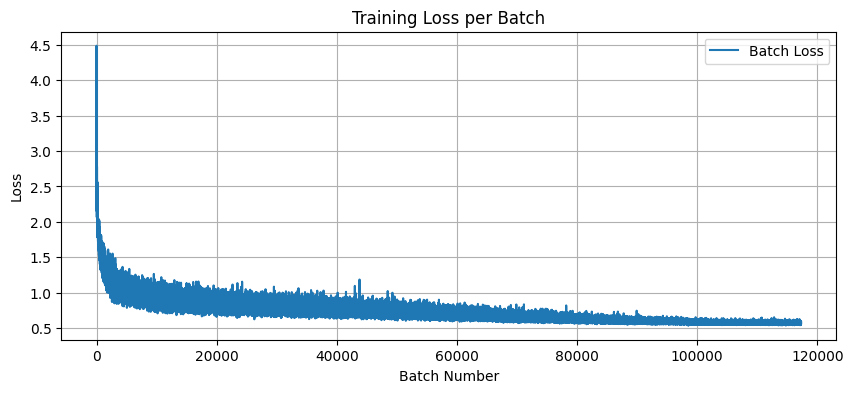

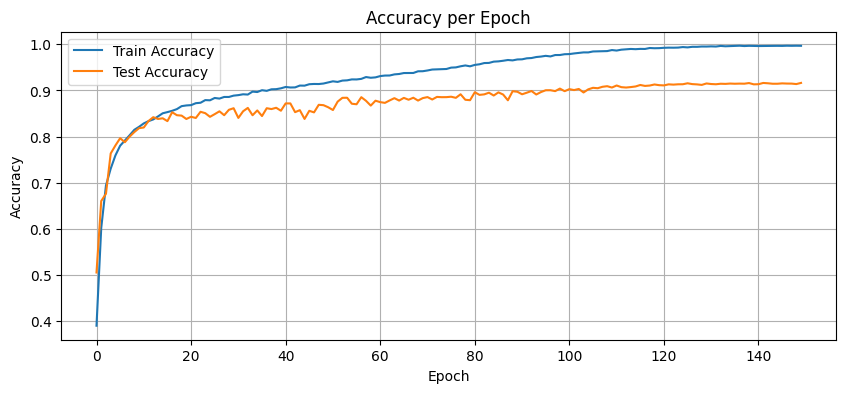

In [9]:
print(f'Best test accuracy: {best_test_accuracy}')

plt.figure(figsize=(10, 4))
plt.plot(train_batch_losses, label='Batch Loss')
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_epoch_accuracies, label='Train Accuracy')
plt.plot(test_epoch_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()